# ELEN90077 Grid Integration of Renewables
# Workshop Week 3 "**PV Hosting Capacity and Volt-Watt Control**"

## 1. Introduction 

### Objectives 
The objectives of this workshop are:
1. To familiarise with the process by which power engineers can assess the effects of the Volt-Watt control function (available in most residential PV inverters and used by most standards around the world) on voltages and, thus, on PV hosting capacity.

2. To continue familiarising with the advanced tool [OpenDSS](https://www.epri.com/pages/sa/opendss) (using Python and the [dss_python](https://github.com/dss-extensions/dss_python) module). And, to guide you, all will be done using a notebook on [Jupyter Notebook](https://jupyter.org/).

### Structure of this Document
The rest of this document is divided into three parts:

- **2. Tutorial.** You will learn how to model the Volt-Watt control function using simple network similar to the one used in **`Workshop Week 1`** ["Advanced Tools for LV Network Analysis"](https://github.com/Team-Nando-Teaching/ELEN90077_2023_Workshop-Week1-Advanced-Tools-LV).
- **3. Questions.** Here you will have a list of questions you need to go through. The corresponding answers will be included in the **Report**.
- **4. Simulation Workspace.** Here you can place all your code to run it at once. You should use **`code`** that is relevant to each question 

<font color='red'>**<u>Note</u>:**</font> Make sure to understand well how to model the network, particularly how to model the PV inverter Volt-Watt control function (2. Tutorial), because this will be crucial for answering the questions. If you make a mistake when modelling the network, your results will be incorrect.

## 2. Tutorial   

We will first create the simple LV network shown in the figure below. We have a transformer (11kV/0.4kV), a three-phase line connecting bus A with bus B, and three single-phase lines connecting bus B with buses C, D, and E. Buses C, D, and E represent the connection points of three different houses.
* The 11kV and 0.4kV are line-to-line nominal values. Thus, the single-phase houses will have a nominal line-to-neutral value of 230V.


<center> <img style="float: middle;" src="Figure_1.png" width="40%"> </center>

**<center>Figure 1. Simple LV Network</center>**

**The Volt-Watt Control Funcion**. It operates by setting a power output limit as a function of the grid voltage (at the connection point of the PV inverter). As the voltage increases or decreases, the power output of the PV system is adjusted accordingly. The function is usually defined by two parameters: the slope and the intercept. The slope determines the rate at which the power output decreases as the voltage increases, while the intercept sets the power output limit at a specified voltage (Fig.2). As it can be seen in the figure, **there are four setpoints (each with X [voltage] and Y [generation] coordinates) that define how the Volt-Watt control function behaves**.

<center> <img style="float: middle;" src="VW.jpg" width="40%"> </center>

**<center> Figure 2. Volt-Watt Control Function</center>** 


<font color='purple'>**<u>Tech Note</u>:**</font> The PV inverter senses voltages where it is located. But this could be many meters away from the connection point to the grid (where the energy meter or smart meter is). Imagine a big house. This means that the voltage seen by the inverter is likely to be higher than that at the grid connection point (due to the impedance).

Follow the steps below. **And let's begin!**

<font color='red'>**<u>Note</u>:**</font> You will need to run the code in each cell. Select the code cell (a <font color='green'>**green box [ ]**</font> surrounding the cell will appear) and then click on the &#9654; **`Run`** button on top of the page to run the corresponding code (or use the shortcut `Control`-`Enter`). Since you will be running code, **you will need to run the cells sequentially**, one after the other without skipping code cells. A number will appear inside the brackets [X] indicating the number of the *run*.

### 2.1 Load Modules and Libraries
First, we need to run the code below to load the modules and the libraries that will be used in this workshop. The purpose of these modules and libraries is:

* **os:** Operating system module, it will be used to get the directory path.
* **dss:** Module for interfacing Python code with OpenDSS. Here is more info about [dss_python](https://github.com/dss-extensions/dss_python) and other [DSS Extensions](https://dss-extensions.org/).
* **matplotlib.pyplot:** Library for creating static, animated, and interactive visualizations in Python
* **numpy:** Library that adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.  
    * The word `as` in the import of both libraries is used to give another shorter name that will be used in the code, such as `plt` and `np`.

<font color='red'>**<u>Note</u>:**</font> If there is an error in this step, that means that some of the modules are not installed in your computer, so go back to the info provided on Canvas and make sure you have everything installed.

In [1]:
import os
import dss
import matplotlib.pyplot as plt
import numpy as np

<a id='4'></a>
### 2.2 Set the working path
Run the code in the cell below to get your working path. As an output you get the location of this notebook in your computer.  

<font color='red'>**<u>Note 1</u>:**</font> Your path should not have spaces. Here is an example with no spaces: `C:\Users\student_name\Desktop\ELEN90077_Workshops`.

<font color='red'>**<u>Note 2</u>:**</font> If you are a MAC user, there may be some errors due to the different use of slash/backslash when defining a path. By changing `/` instead of `\`, you will fix the problem. For instance, you can change `\\Residential..` with `/Residential..`.

<font color='red'>**<u>Note 3</u>:**</font> You should always open the Jupyter Notebook file from the folder that you uploaded to Jupyter Notebook. If you want to continue working later, you can simply save the changes and then open the **.ipynb** file again and continue working from where you left.

In [2]:
my_directory = os.getcwd()
print(f"The direction is located in the following path: my_directory = {my_directory}")

The direction is located in the following path: my_directory = C:\Users\ASIMONOVSKA\Documents\GitHub\ELEN90077_2023_Workshop-Week3-PV-Hosting-Capacity-VoltWatt


### 2.3 Set up dss_engine
Before running the code in Python, we need to set up the **dss_engine** which will be used for OpenDSS commands.


In [3]:
dss_engine = dss.DSS
DSSText = dss_engine.Text
DSSCircuit = dss_engine.ActiveCircuit
DSSSolution = dss_engine.ActiveCircuit.Solution
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue
dss_engine.AllowForms = 0

<font color='red'>**<u>Note</u>:**</font> The code corresponding to sections `2.4` to `2.8` below have already been explained in detail in **`Workshop Week 1`**. So, no further explanations are provided here.

### 2.4 Create the Circuit

In [4]:
DSSText.Command = 'Clear'
DSSText.Command = 'Set DefaultBaseFrequency=50'
DSSText.Command = 'New Circuit.Simple_LV_Network'
DSSText.Command = 'Edit vsource.source bus1=sourceBus basekv=11 pu=1.0 phases=3'

### 2.5 Add the 11kV/0.4kV Transformer  

In [5]:
DSSText.Command = 'New transformer.LVTR Buses=[sourcebus, A.1.2.3] Conns=[delta wye] KVs=[11, 0.433] KVAs=[250 250] %Rs=0.00 xhl=2.5 %loadloss=0 '

### 2.6 Create the linecodes 

In [6]:
DSSText.Command = 'new linecode.240sq nphases=3 R1=0.127 X1=0.072 R0=0.342 X0=0.089 units=km'
DSSText.Command = 'new linecode.16sq nphases=1 R1=1.15 X1=0.083 R0=1.2 X0=0.083 units=km'

### 2.7 Create the 400V and 230V lines

In [7]:
DSSText.Command = 'new line.A_B bus1=A.1.2.3 bus2=B.1.2.3 length=1 phases=3 units=km linecode=240sq'
DSSText.Command = 'new line.B_L1 bus1=B.1 bus2=C.1 length=0.1 phases=1 units=km linecode=16sq'
DSSText.Command = 'new line.B_L2 bus1=B.2 bus2=D.1 length=0.1 phases=1 units=km linecode=16sq'
DSSText.Command = 'new line.B_L3 bus1=B.3 bus2=E.1 length=0.1 phases=1 units=km linecode=16sq'

### 2.8 Connect loads to a bus  
We need to model each single-phase load (each house) according to Figure 1.
* <font color= red>Red house</font> (bus C) will be represented by Load_1 (using <font color= red> phase 1</font>)
* <font color= blue>Blue house</font> (bus D) will be represented by Load_2 (using  <font color= blue> phase 2</font>)
* <font color= limegreen> Green house </font> (bus E) will be represented by Load_3 (using <font color= limegreen> phase 3</font>)  

<center> Table 1. Load Parameters</center>

| Load Name | Phases | Connected bus | Peak Demand (kW) |  PF  |
|:---------:|:------:|:-------------:|:-----------:|:----:|
|   Load_1  |    1   |       C       |      3      | 0.95 |
|   Load_2  |    1   |       D       |      2      | 0.95 |
|   Load_3  |    1   |       E       |      5      | 0.95 |

In [8]:
DSSText.Command = 'new load.Load_1 bus1=C.1 phases=1 kV=(0.4 3 sqrt /) kW=3 pf=0.95 model=1 conn=wye Vminpu=0.85 Vmaxpu=1.20 status=fixed'
DSSText.Command = 'new load.Load_2 bus1=D.1 phases=1 kV=(0.4 3 sqrt /) kW=2 pf=0.95 model=1 conn=wye Vminpu=0.85 Vmaxpu=1.20 status=fixed'
DSSText.Command = 'new load.Load_3 bus1=E.1 phases=1 kV=(0.4 3 sqrt /) kW=5 pf=0.95 model=1 conn=wye Vminpu=0.85 Vmaxpu=1.20 status=fixed'

### 2.9 Select the relevant scenario

To understand the Volt-Watt control function and its effect on customers voltages, we'll be conducting a simulation using three different scenarios:
- **Scenario 1**: No PV systems are connected to the houses
- **Scenario 2**: PV systmes are connected to the houses without Volt-Watt control function
- **Scenario 3**: PV systems are connected to the houses with Volt-Watt control function

These scenarios will be coded as a dictionary named `scenarios`. The dictionary is a powerful data structure in Python where we can store and/or collect values for a specific keys (the key being the scenario, the values being those describing each scenario). As such we will use the variables `pv` (with [1] or without PV [0]), `inv` (inverter with [1] or without [0] control functions), and `inv_ctrl` (Volt-Watt is enabled [true] or not [false]).

- **Scenario 1**: No PV systems are connected to the houses **>>** `pv=0`, `inv=0`, `inv_ctrl=false`
- **Scenario 2**: PV systems are connected to the houses without Volt-Watt control function **>>** `pv=1`, `inv=0`, `inv_ctrl=false`
- **Scenario 3**: PV systems are connected to the houses with Volt-Watt control function **>>** `pv=1`, `inv=1`, `inv_ctrl=true`

In [9]:
scenarios = {1: {"pv": 0, "inv": 0, "inv_ctrl": "false"},
             2: {"pv": 1, "inv": 0, "inv_ctrl": "false"},
             3: {"pv": 1, "inv": 1, "inv_ctrl": "true"}}

The next step is to choose which scenario you want to run by changing the value of the variable `scn` (short for scenario). 

- In order to reduce any errors that may happen when changing the `scn` number, two extra lines of code are added to force an exception to occur if the `scn` number is not 1, 2 or 3.

- The values of the scenarios will be stored in the corresponding variables so they can be used later.

<font color='red'>**<u>Note</u>**</font>: In this Tutorial we will only explain **Scenario 3** as the other two scenarios have been investigated in previous workshops. So change the `scn=3`.

In [10]:
scn = 2

if scn not in [1, 2, 3]:
    raise ValueError(f"Scenario cannot be {scn}. It can only be 1, 2, or 3")

pv = scenarios[scn]["pv"]
inv = scenarios[scn]["inv"]
inv_ctrl = scenarios[scn]["inv_ctrl"]

### 2.10 Set up the Volt-Watt control function
Since we are running the simulation for Scenario 3 (`pv=1`, `inv=1`, `inv_ctrl=true`), all customers will have PV systems and each PV inverter will have the Volt-Watt control enabled. 
- First, you need to add PV systems to the houses. The corresponding details and code has already been provided in **`Workshop Week 1`**.
- To model the Volt-Watt control function in OpenDSS, the four setpoints (P1, P2, P3, P4) of the control function (Fig. 2) are given in 2 arrays: `XArray` and `YArray`.
  - The values of the XArray (0.5, 1.095, 1.100, 1.5) are on the x-axis of the Volt-Watt graph.
  - The values of the YArray (1.0, 1.0, 0.0, 0.0) are on the y-axis of the Volt-Watt graph.
  - You can notice that these particular setpoints mean that for voltage magnitudes larger or equal to 1.1 p.u., the PV system does not have any output (the output is set to zero).
- In order to model the inverter control function, we will use two `DSSText.Command` lines: 
    - The first line introduces the Volt-Watt curve, consisting of four points, with (x,y) coordinates corresponding to the values of the X and Y arrays.
    - The second line models the inverter control function, where: 
        - `mode=VOLTWATT` sets the mode of the inverter control function. The mode is set to Volt-Watt which means the control adjusts the inverter's active power output in response to changes in voltages.
        - `voltage_curvex_ref=rated` sets the reference voltage for the Volt-Watt curve and itt is set to the rated voltage of the system.
        - `voltwatt_curve=vw_curve_1` sets the name of the Volt-Watt curve to be used for the control. Here the curve is called `vw_curve_1`.
        - `DeltaP_factor` sets the scaling factor for the change in active power output (DeltaP) as a function of the change in grid voltage. In this case, the scaling factor is set to 0.1.
        - `voltagechangetolerance` sets the maximum voltage change tolerance for the inverter control. If the voltage change is greater than 0.0001 value, the control will adjust the inverter's active power output.
        - `varchangetolerance` sets the maximum reactive power change tolerance for the inverter control. If the reactive power change is greater than 0.1 value, the control will adjust the inverter's active power output.
        - `enabled={inv_ctrl}` specifies whether the inverter control is enabled or disabled. The string value of `inv_ctrl` is used to set this parameter dynamically using scenarios dictionary.

In [11]:
if pv == 1:
    DSSText.Command = 'new PVSystem.PV1 bus1=C.1 phases = 1 kva = 10 pmpp = 10 pf = 1 kV=(0.4 3 sqrt /) model=1'
    DSSText.Command = 'new PVSystem.PV2 bus1=D.1 phases = 1 kva = 10 pmpp = 10 pf = 1 kV=(0.4 3 sqrt /) model=1'
    DSSText.Command = 'new PVSystem.PV3 bus1=E.1 phases = 1 kva = 10 pmpp = 10 pf = 1 kV=(0.4 3 sqrt /) model=1'
    
    if inv == 1:
        X_array = "(0.5, 1.095, 1.100, 1.5)"
        Y_array = "(1.0, 1.0, 0.0, 0.0)"

        DSSText.Command = f'New XYCurve.vw_curve_1 npts=4 Yarray={Y_array} XArray={X_array}'
        DSSText.Command = f'New InvControl.InvPVCtrl mode=VOLTWATT voltage_curvex_ref=rated ' \
                          f'voltwatt_curve=vw_curve_1 DeltaP_factor=0.1 voltagechangetolerance=0.0001 varchangetolerance=0.1 ' \
                          f'enabled={inv_ctrl} EventLog=no'

### 2.11 Set the control mode and the voltage bases
Since at this stage we are not controlling network elements (e.g., on-load tap changers) nor we are doing time-varying analyses, we will set our `controlmode` and `mode` to **static** and **snapshot**, respectively. We are just doing a simple, single power flow run.

Here we also set the voltage bases of the circuit (**`Set VoltageBases= [11.0, 0.4]`** in the code).

And with the command **`calcvoltagebases`** we obtain the p.u. values of the voltages. 

Finally, we set the `DSSText.Command = 'Set maxcontroliter=1000'`. This command is used when running complex simulations that involve a large number of control devices (e.g., having many houses with PV and the Volt-Watt enabled) or when convergence issues arise during the simulation. By increasing the maximum number of control iterations, you allow OpenDSS to spend more time attempting to converge on a solution before giving up. The default value is 15.

<font color='red'>**<u>Note</u>**:</font> Setting a very high value for the maximum number of control iterations may cause simulations to take longer to run, as OpenDSS will spend more time trying to converge on a solution. Therefore, it's best to set this value to a reasonable level based on the complexity of the simulation and the convergence behavior of the system being modeled. Is there a magic number? No. It requires a bit of trial and error as networks and scenarios can be very different. But 1000 is OK for this workshop.

In [12]:
DSSText.Command = 'set controlmode=static'
DSSText.Command = 'set mode=snapshot'
DSSText.Command = 'Set VoltageBases=[11 0.4]'
DSSText.Command = 'calcvoltagebases'
DSSText.Command = 'Set maxcontroliter=1000'

### 2.12 Run the power flow simulation  
We will run the power flow simulation for our circuit using the command **`DSSSolution.Solve()`**.

If the Solution converged, you will see a note saying so (and the results if applicable). If not, then there is a mistake in the code. In that case, usually a <font color='red'>DSSException</font> cell appears bellow the cell that has an error, giving direction where the error is located.

<font color='red'>**<u>Note</u>:**</font> This command comes **after modelling all of the elements of the network**.


In [13]:
DSSSolution.Solve()
if DSSSolution.Converged:
    print("The Circuit was Successfully Solved :-)")
    print("\n")

The Circuit was Successfully Solved :-)




### 2.13 Extract the results
Once we have solved the circuit we can **extract the results** from the successful power flow simulation.

There are different ways and different commands for extracting the results. Some of them are listed below.

#### 2.13.1 Plotting the voltage profiles per connection bus and per phase 

* First, the three-phase and single-phase buses are separated. 
* Then, the voltage profiles per phase are stored in the corresponding variables `v_ph_a`, `v_ph_b` and `v_ph_c`
* Finally, the voltage profiles are presented in the figure below, such that the x-axis shows the buses, and the y-axis the voltage magnitude in p.u.

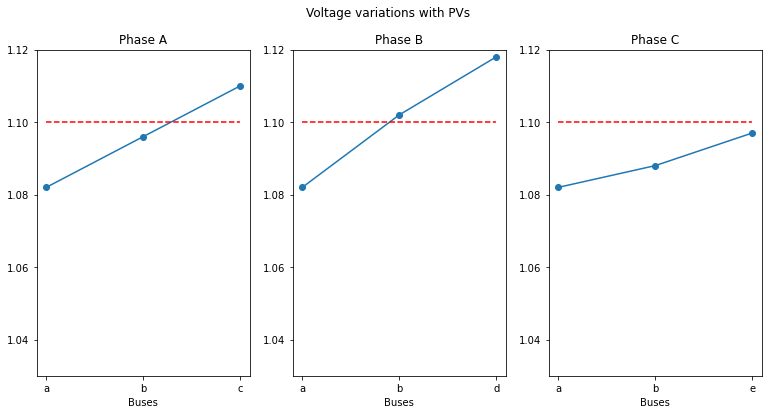

In [14]:
single_phases_buses = []
single_phase_bus_phases = []
three_phase_buses = []
all_buses = DSSCircuit.AllBusNames
for bus_name in all_buses:
    DSSCircuit.ActiveCktElement(DSSCircuit.SetActiveBus(bus_name))
    no_phases = DSSCircuit.ActiveCktElement.NumPhases
    if bus_name != "sourcebus":
        if no_phases == 3:
            three_phase_buses.append(bus_name)
        else:
            single_phases_buses.append(bus_name)
            line_name = DSSCircuit.ActiveCktElement.Name.split(".")[1]
            DSSCircuit.SetActiveElement(f"Line.{line_name}")
            bus_names = DSSCircuit.ActiveCktElement.BusNames
            single_phase_bus_phases.append(bus_names[0].split(".")[1])

all_buses = three_phase_buses + single_phases_buses
v_ph_a = []
v_ph_b = []
v_ph_c = []

for bus_name in all_buses:
    DSSCircuit.SetActiveBus(bus_name)
    if bus_name in three_phase_buses:
        v_ph_a.append(round(DSSCircuit.ActiveBus.puVmagAngle[0], 3))
        v_ph_b.append(round(DSSCircuit.ActiveBus.puVmagAngle[2], 3))
        v_ph_c.append(round(DSSCircuit.ActiveBus.puVmagAngle[4], 3))
    else:
        phase = int(single_phase_bus_phases[single_phases_buses.index(bus_name)])
        if phase == 1:
            v_ph_a.append(round(DSSCircuit.ActiveBus.puVmagAngle[0], 3))
            v_ph_b.append(0)
            v_ph_c.append(0)
        elif phase == 2:
            v_ph_b.append(round(DSSCircuit.ActiveBus.puVmagAngle[0], 3))
            v_ph_a.append(0)
            v_ph_c.append(0)
        else:
            v_ph_c.append(round(DSSCircuit.ActiveBus.puVmagAngle[0], 3))
            v_ph_a.append(0)
            v_ph_b.append(0)

ph_a = [bus for bus in all_buses if v_ph_a[all_buses.index(bus)] != 0]
ph_b = [bus for bus in all_buses if v_ph_b[all_buses.index(bus)] != 0]
ph_c = [bus for bus in all_buses if v_ph_c[all_buses.index(bus)] != 0]
v_ph_a = [v for v in v_ph_a if v != 0]
v_ph_b = [v for v in v_ph_b if v != 0]
v_ph_c = [v for v in v_ph_c if v != 0]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 6))
names = {0: "Phase A", 1: "Phase B", 2: "Phase C"}
for ph, (v, ph_buses) in enumerate(zip([v_ph_a, v_ph_b, v_ph_c], [ph_a, ph_b, ph_c])):
    axs[ph].plot(v, marker="o")
    axs[ph].plot([0, 2], [1.1, 1.1], 'r--')
    ticks = np.arange(len(v))
    axs[ph].set_xticks(ticks)
    axs[ph].set_xticklabels(ph_buses)
    axs[ph].title.set_text(f"{names[ph]}")
    axs[ph].set_xlabel("Buses",)
    axs[ph].set_ylim([1.03, 1.12])

if pv == 1:
    if pv == 1 and inv == 0:
        fig.suptitle('Voltage variations with PVs')
    else: 
        fig.suptitle('Voltage variations with PVs and inverter controls')    
else:
    fig.suptitle('Voltage variations without PVs')
plt.show()


#### 2.13.2 Plotting the power exported with and without inverter control function 

The code below shows how to present the PV systems exported power `with` and `without` inverter control function using bar plots. 

- First, all PV systems used in the current simulation are stored in the variable `pv_names`. 
- Then, their active power (P) is stored in the variable `p_export` for all PV systems in order as in `pv_names`.
- Finally, a plots is produced: 
   - Either one using the inverter control function (**if inv==1** part) 
   - Or, the one without using the control function (**else** part)


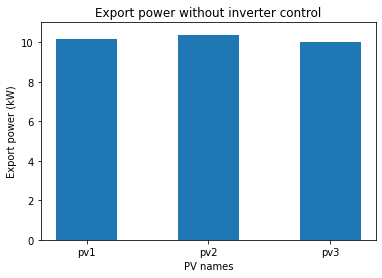

In [15]:
p_export = []
if pv == 1:
    pv_names = DSSCircuit.PVSystems.AllNames
    for pv in pv_names:
        DSSCircuit.SetActiveElement(f"PVSystem.{pv}")
        p_export.append(abs(round(DSSCircuit.ActiveElement.Powers[0], 3)))

    plt.subplots()
    plt.bar([0, 1, 2], p_export, 0.5)
    plt.xticks([0, 1, 2], pv_names)
    plt.ylim([0, 11])
    plt.xlabel("PV names")
    plt.ylabel("Export power (kW)")
    if inv == 1:
        plt.title('Export power with inverter control')
    else:
        plt.title('Export power without inverter control')
    plt.show()

## 3. Questions

First, read all the questions so you understand the purpose of each question.

At the very end of this notebook in **4. Workshop Simulation**, you will be able to place all your code to run it at once. Remember, you should use **`code`** that is relevant to each question.

<font color='red'>**<u>Note</u>:**</font> Keep your results/answers in a separate document as they will be needed in your **Report**.

### **Question 1: PV Hosting Capacity using Volt-Watt control for the Test LV Circuit in [Tutorial-DERHC-2](https://github.com/Team-Nando/Tutorial-DERHostingCapacity-2-TimeSeries_LV) `[Total 60 marks]`**

In this question, you will use the LV network (figure below) from **`Tutorial-DERHC-2`** to study the effects of the Volt-Watt control function when using different settings.

<img style="float: middle;" src="LVcircuit-topology.png" width="60%">

- For better access, the **.dss** and **.txt** files of the LV circuit are given in the folder **`TestLVCircuit`**.

Similarly as in **`Workshop Week 2`**, you will also need to **modify the original code** from **`Tutorial-DERHC-2`** as follows:

- Change the `start_day` for each season according to **Q1.1**.  
  - **Note** that you will have to run the simulation `only` for that day of the season (**`total_days=1`**), which means the **demand is already defined** by selecting that day and the pre-defined random seed.
- Use the already selected PV profile per season that is in the folder of this workshop (see below).    
  - **Differently** from **`Workshop Week 2`**, in this workshop you **do not need to select the PV profile**. It is only one PV profile in the `.npy` file, so use the PV profile for the corresponding season.
  - The instructions on how to use the PV profile were already given in **`Workshop Week 2`**.
<img style="float: middle;" src="Figure 12.png" width="30%">

- **Include the code for Volt-Watt control function in the code block for the PV systems.**    
  - **Note** that you should place the code for the curves (Xarray, Yarray and the DSSText.Commands) in the code block **4.5** from the [Tutorial-DERHC-2](https://github.com/Team-Nando/Tutorial-DERHostingCapacity-2-TimeSeries_LV). 
  - The place of the code should be **only** under the main **for loop** `for iday in range(start_day,start_day+total_days):` and before the **reset command** (`DSSText.Command = 'Reset' `)
  - **Do not** place the code under any inner **for loop**!
- **Select** the **best curve** from the three provided curves in question Q1.1 (`Curve 1`, `Curve 2`, and `Curve 3`). Consider the benefits to both the user and the distribution network.


**Q1.1:** Starting from 0% PV penetration, increase the penetration by 20%, up to 100% PV penetration for **each** of the given days per season (also using the pre-selected PV profile). Select the **best curve** from three curves below. Discuss why you chose that curve. <font color='blue'>**[20 marks]**</font>

   - **Summer Day: `start_day=28`**
   - **Autumn Day: `start_day=54`** 
   
- `Curve 1`:
    - **X_array = "(0.500, 1.090, 1.100, 1.500)"**  
    - **Y_array = "(1.0, 1.0, 0.0, 0.0)"**
    
- ` Curve 2`:
    - **X_array = "(0.500, 1.095, 1.100, 1.500)"**
    - **Y_array = "(1.0, 1.0, 0.0, 0.0)"**
    
- `Curve 3`:
    - **X_array = "(0.500, 1.095, 1.104, 1.500)"**
    - **Y_array = "(1.0, 1.0, 0.0, 0.0)"**


**Q1.2:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only**, visualise the Voltage profiles of the customers **without** and **with** Volt-Watt control function **only for the summer day**. You should have 6 graphs in total. <font color='blue'>**[15 marks]**</font> 

**Q1.3:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only**, visualize the aggregated (total) curtailed power at 14:00h from customers PV systems **only for the summer day**. You can do all three PV penetrations in one graph. <font color='blue'>**[10 marks]**</font>

**Q1.4:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only** visualize the curtailed power of the PV system as a time-series plot for the following customers: **3, 15, 30** **only for the summer day**. You can plot the three-customers together for each PV penetration, which means 3 graphs in total. <font color='blue'>**[10 marks]**</font>

**Q1.5:** What is the PV Hosting Capacity when using **`Curve 3`** when assesed on both seasons? <font color='blue'>**[5 marks]**</font>

### **Question 2: PV Hosting Capacity using Volt-Watt control for the LV Network with 4 Feeders** `[Total 40 marks]`

In this question, you will use a the LV network with four 3-phase LV feeders and 89 residential single-phase customers (as shown in the figure below) and you will model the Volt-Watt control function to the customers PV inverters.

<img style="float: middle;" src="Picture_2.svg" width="60%">

Use the same code you developed in **`Workshop Week 2`**. 
- For better access, the **.dss** and **.txt** files of the LV circuit are given in the folder **`LVNetwork4Feeders`**.
- Change the `start_day` using the days given in **Q1.1** as required in questions **Q2.1 to Q2.4**.
  - **Note** that you will have to run the simulation `only` for that day of the season (**`total_days=1`**), which means the **demand is already defined** by selecting that day and the pre-defined random seed.
- Use the already selected PV profile per season that is in the folder of this workshop.  
  - The instructions on how to use the PV profile were already given in **`Workshop Week 2`**.

- **Include the code for Volt-Watt control function in the code block for the PV systems.**  
  - **Note** that you should place the code for the curves (Xarray, Yarray and the DSSText.Commands) in the code block **4.5** from the [Tutorial-DERHC-2](https://github.com/Team-Nando/Tutorial-DERHostingCapacity-2-TimeSeries_LV). 
  - The place of the code should be **only** under the main **for loop** `for iday in range(start_day,start_day+total_days):` and before the **reset command** (`DSSText.Command = 'Reset' `)
  - **Do not** place the code under any inner **for loop**!
- Use the already selected **best curve** from the three provided curves in question **Q1.1** (`Curve 1`, `Curve 2`, and `Curve 3`)  

**Q2.1:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only**, visualise the Voltage profiles of the customers **without** and **with** Volt-Watt control function **only for the autumn day**. You should have 6 graphs in total. <font color='blue'>**[15 marks]**</font> 

**Q2.2:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only**, visualize the aggregated (total) curtailed power at 14:00h from customers PV systems **only for the autumn day**. You can do all three PV penetrations in one graph. <font color='blue'>**[10 marks]**</font>

**Q2.3:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only** visualize the curtailed power of the PV system as a time-series plot for the following customers: **5, 44, 89** **only for the autumn day**. You can plot the three-customers together for each PV penetration, which means 3 graphs in total. <font color='blue'>**[10 marks]**</font>

**Q2.4:** What is the PV Hosting Capacity when using **`Curve 3`** when assesed on both seasons? <font color='blue'>**[5 marks]**</font>

## 4. Workshop Simulation